In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install --upgrade gdown
!gdown 1c-A1oTteY67zDD2S4FXrAHtqNfdrEnMf
!gdown 1pWY1KBMFBezJbpunuaePlkqTT0a9S56u

import nltk, random, html, re, subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
# from torch.autograd import Variable
# import torch.nn.functional as F
# from sklearn.feature_extraction.text import CountVectorizer
# from functools import partial
# from torchtext.data import get_tokenizer
# from torchtext.vocab import Vocab, build_vocab_from_iterator
# from torch.nn.utils import clip_grad_norm_
# from torch.nn.functional import sigmoid, logsigmoid

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, recall_score, f1_score, confusion_matrix

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

Downloading...
From: https://drive.google.com/uc?id=1c-A1oTteY67zDD2S4FXrAHtqNfdrEnMf
To: /kaggle/working/test.csv
100%|███████████████████████████████████████| 1.50M/1.50M [00:00<00:00, 130MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pWY1KBMFBezJbpunuaePlkqTT0a9S56u
To: /kaggle/working/train.csv
100%|██████████████████████████████████████| 23.9M/23.9M [00:00<00:00, 48.9MB/s]
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
try:
    nltk.data.find('punkt.zip')
except:
    nltk.download('punkt', download_dir='/kaggle/working/')
    subprocess.run("unzip /usr/share/nltk_data/corpora/punkt.zip -d /usr/share/nltk_data/corpora/".split())
    nltk.data.path.append('/kaggle/input')


[nltk_data] Downloading package punkt to /kaggle/working/...
[nltk_data]   Unzipping tokenizers/punkt.zip.


unzip:  cannot find or open /usr/share/nltk_data/corpora/punkt.zip, /usr/share/nltk_data/corpora/punkt.zip.zip or /usr/share/nltk_data/corpora/punkt.zip.ZIP.


In [4]:
try:
    nltk.data.find('stopwords.zip')
except:
    nltk.download('stopwords', download_dir='/kaggle/working/')
    subprocess.run("unzip /usr/share/nltk_data/corpora/stopwords.zip -d /usr/share/nltk_data/corpora/".split())
    nltk.data.path.append('/kaggle/input')

[nltk_data] Downloading package stopwords to /kaggle/working/...
[nltk_data]   Unzipping corpora/stopwords.zip.
Archive:  /usr/share/nltk_data/corpora/stopwords.zip


replace /usr/share/nltk_data/corpora/stopwords/dutch? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


In [5]:
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    subprocess.run("unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/".split())
    nltk.data.path.append('/kaggle/input')

[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/

In [6]:
# Read the data
train_df = pd.read_csv("train.csv")
corpus_train = train_df["Description"].to_numpy()
# tokenizer = get_tokenizer("basic_english")
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '?', '-', ':', ';', '$', '%', '!', 's'])
# symbols = sorted(['.', ',', '?', '-', ':', ';', '$', '%', '!', 's'])
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r"([a-zA-Z]+)n[\'’]t", r"\1 not", text)
    text = re.sub(r"([iI])[\'’]m", r"\1 am", text)
    text = re.sub(r"([iI])[\'’]ll", r"\1 will", text)
    text = re.sub(r"[^a-zA-Z0-9\:\$\-\,\%\.\?\!]+", " ", text)
    text = html.unescape(text)
    text = re.sub(r"_(.*?)_", r"\1", text)
    text = re.sub(r'(\w+)-(\w+)', r'\1\2', text)
    return text

# def tokenize_text(text, symbols, lemmatizer):
def tokenize_text(text, stop_words, lemmatizer):
    tokens = word_tokenize(text)
    # tokens = [token.lower() for token in tokens]
    tokens = [token.lower() for token in tokens if token.isalpha()]  # Remove non-alphabetic tokens
    tokens = [token for token in tokens if token not in stop_words]  # Remove stopwords
#     tokens = [token for token in tokens if token not in symbols]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatize tokens
    return tokens


tokens_train = []
for sent in corpus_train:
#     tokens_train.append(tokenize_text(clean_text(sent), symbols, lemmatizer))
    tokens_train.append(tokenize_text(clean_text(sent), stop_words, lemmatizer))
    # tokens_train.append(sent)

train_df['Description'] = [' '.join(tokens) for tokens in tokens_train]

test_df = pd.read_csv("test.csv")
corpus_test = test_df["Description"].to_numpy()
tokens_test = []
for sent in corpus_test:
#     tokens_test.append(tokenize_text(clean_text(sent), symbols, lemmatizer))
    tokens_test.append(tokenize_text(clean_text(sent), stop_words, lemmatizer))
#     # tokens_test.append(sent)

test_df['Description'] = [' '.join(tokens) for tokens in tokens_test]

# from sklearn.preprocessing import LabelEncoder
# Convert class labels to numeric
# LabEnc = LabelEncoder()
# train_df['Class Index'] = LabEnc.fit_transform(train_df['Class Index'])
# test_df['Class Index'] = LabEnc.fit_transform(test_df['Class Index'])

# corpus_train = train_df["Description"].to_numpy()
# corpus_test = test_df["Description"].to_numpy()
# # Build Vocabulary
# MIN_WORD_FREQUENCY = 1
# vocab_train = build_vocab_from_iterator(tokens_train, min_freq=MIN_WORD_FREQUENCY, specials=["<unk>"])
# vocab_train.set_default_index(vocab_train["<unk>"])
# vocab_test = build_vocab_from_iterator(tokens_test, min_freq=MIN_WORD_FREQUENCY, specials=["<unk>"])
# vocab_test.set_default_index(vocab_test["<unk>"])

# print(f"Total sentences in train text: {len(tokens_train)}")
# print(f"Unique train words: {len(vocab_train)}")
# print(f"Total sentences in test text: {len(tokens_test)}")
# print(f"Unique test words: {len(vocab_test)}")

# with open("vocab_train.pkl", "wb") as f:
#     pickle.dump(vocab_train, f)
# with open("vocab_test.pkl", "wb") as f:
#     pickle.dump(vocab_test, f)

# Extract descriptions
descriptions = train_df['Description'].tolist()


# Tokenize the descriptions
tokenized_descriptions = [description.split() for description in descriptions]

# Define vocabulary
vocabulary = sorted(set(word for description in tokenized_descriptions for word in description))
word_to_index = {word: idx for idx, word in enumerate(vocabulary)}
vocab_size = len(vocabulary)
# Convert vocabulary to list for indexing
vocab_list = list(vocabulary)


train_df['CleanDescriptionTokens'] = tokenized_descriptions

def tokenize_text2(text, vocabulary):
    tokens = word_tokenize(text)
    # tokens = [token.lower() for token in tokens]
    # tokens = [token.lower() for token in tokens if token.isalpha()]  # Remove non-alphabetic tokens
    tokens = [token if token in word_to_index else 'unk' for token in tokens]
    # Remove stopwords
    # tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatize tokens
    return tokens

corpus_test2 = test_df["Description"].to_numpy()
tokens_test2 = []
for sent in corpus_test2:
    tokens_test2.append(tokenize_text2(sent, vocabulary))
#     # tokens_test.append(sent)

test_df['Description'] = [' '.join(tokens) for tokens in tokens_test2]

tokenized_descriptions_test = test_df['Description'].tolist()
test_df['CleanDescriptionTokens'] = [description.split() for description in tokenized_descriptions_test]

In [7]:
flatten = lambda l: [item for sublist in l for item in sublist]
random.seed(1024)
USE_CUDA = torch.cuda.is_available()
gpus = [0]
#torch.cuda.set_device(gpus[0])

# FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
# ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

def getBatch(batch_size, train_data):
#     random.shuffle(train_data)
    sindex = 0
    eindex = batch_size
    while eindex < len(train_data):
        batch = train_data[sindex: eindex]
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        yield batch

    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch

# def prepare_sequence(seq, word2index):
#     idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index['unk'], seq))
#     return Variable(LongTensor(idxs))

# def prepare_word(word, word2index):
#     return Variable(LongTensor([word2index[word]]) if word2index.get(word) is not None else LongTensor([word2index['unk']]))


def prepare_sequence(seq, word2index):
    idxs = [word2index[w] if w in word2index else word2index['unk'] for w in seq]
    return torch.tensor(idxs, dtype=torch.long, device='cuda' if USE_CUDA else 'cpu')


def prepare_word(word, word2index):
    if word in word2index:
        idx = word2index[word]
    else:
        idx = word2index['unk']
    return torch.tensor([idx], dtype=torch.long, device='cuda' if USE_CUDA else 'cpu')


In [8]:
def negative_sampling(targets, unigram_table, k, word2index):
    batch_size = targets.size(0)
    neg_samples = []
    for i in range(batch_size):
        nsample = []
        target_index = targets[i].data.cpu().tolist()[0] if USE_CUDA else targets[i].data.tolist()[0]
        while len(nsample) < k: # num of sampling
            neg = random.choice(unigram_table)
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample, word2index).view(1, -1))

    return torch.cat(neg_samples)

class SkipgramNegSampling(nn.Module):

    def __init__(self, vocab_size, projection_dim):
        super(SkipgramNegSampling, self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, projection_dim) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, projection_dim) # out embedding
        self.logsigmoid = nn.LogSigmoid()

        initrange = (2.0 / (vocab_size + projection_dim))**0.5 # Xavier init
        self.embedding_v.weight.data.uniform_(-initrange, initrange) # init
        self.embedding_u.weight.data.uniform_(-0.0, 0.0) # init

    def forward(self, center_words, target_words, negative_words):
        center_embeds = self.embedding_v(center_words) # B x 1 x D
        target_embeds = self.embedding_u(target_words) # B x 1 x D

        neg_embeds = -self.embedding_u(negative_words) # B x K x D

        positive_score = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2) # Bx1
        negative_score = torch.sum(neg_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2), 1).view(negs.size(0), -1) # BxK -> Bx1

        loss = self.logsigmoid(positive_score) + self.logsigmoid(negative_score)

        return -torch.mean(loss)

    def prediction(self, inputs):
        embeds = self.embedding_v(inputs)

        return embeds

In [9]:
# word2index['unk']

In [10]:
class SentenceDataset(Dataset):
    def __init__(self, sentences, labels, word_embeddings):
        self.sentences = sentences
        self.labels = labels
        self.word_embeddings = word_embeddings

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        # print(text)
        label = self.labels[idx]
        # Convert text to embedding
        embedding = torch.tensor(np.array([self.word_embeddings[word] if word in word2index else word_embeddings['unk'] for word in sentence]), dtype=torch.float)
#         tokens = [token if token in word_to_index else 'unk' for token in tokens]
        return embedding, label


def collate_fn(batch):
    inputs, labels = zip(*batch)  # Unzip the batch into inputs and labels
    inputs = pad_sequence(inputs, batch_first=True)  # Pad the sequences
    labels = torch.tensor(labels, dtype=torch.long)  # Convert labels to a tensor
    return inputs, labels


class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Assuming x is a padded sequence of embeddings
        lstm_out, (ht, ct) = self.lstm(x)
        return self.fc(ht[-1])




    
def AllSkLMetrics(true_labels, predicted_labels, DatasetType, WINDOW_SIZE, array):
    accuracy = accuracy_score(true_labels, predicted_labels)
    array.append(accuracy)
#     test_accuracies.append(test_accuracy)
    print(f'Accuracy on the {DatasetType} set: {accuracy} for window_size = {WINDOW_SIZE}')

    # Additional Metrics
    print("Classification Report:")
    print(classification_report(true_labels, predicted_labels))

    print("Confusion Matrix:")
    print(confusion_matrix(true_labels, predicted_labels))

    # Micro and Macro Recall
    micro_recall = recall_score(true_labels, predicted_labels, average='micro')
    macro_recall = recall_score(true_labels, predicted_labels, average='macro')
    print(f'Micro Recall: {micro_recall}')
    print(f'Macro Recall: {macro_recall}')

    # Micro and Macro F1 Score
    micro_f1 = f1_score(true_labels, predicted_labels, average='micro')
    macro_f1 = f1_score(true_labels, predicted_labels, average='macro')
    print(f'Micro F1 Score: {micro_f1}')
    print(f'Macro F1 Score: {macro_f1}')
    print()
    print()
    print()

In [11]:
tokenized_descriptions_sub = tokenized_descriptions[:70000]
word_count = Counter(flatten(tokenized_descriptions_sub))
MIN_COUNT = 1
exclude = []
for w, c in word_count.items():
    if c < MIN_COUNT:
        exclude.append(w)

vocab = list(set(flatten(tokenized_descriptions_sub)) - set(exclude))

word2index = {}
for vo in vocab:
    if word2index.get(vo) is None:
        word2index[vo] = len(word2index)

index2word = {v:k for k, v in word2index.items()}



In [18]:
# del windows
# del sample_train_data
# import gc
# gc.collect()

2195

In [13]:
window_sizes = [4,3,2,1]
for WINDOW_SIZE in window_sizes:
    print(f'Window Size = {WINDOW_SIZE}')
    print("TD")
    windows =  flatten([list(nltk.ngrams(['<DUMMY>'] * WINDOW_SIZE + c + ['<DUMMY>'] * WINDOW_SIZE, WINDOW_SIZE * 2 + 1)) for c in tokenized_descriptions_sub])
    print(len(windows))
    sample_train_data = []

    for window in tqdm(windows):
        for i in range(WINDOW_SIZE * 2 + 1):
            if window[i] in exclude or window[WINDOW_SIZE] in exclude:
                continue # min_count
            if i == WINDOW_SIZE or window[i] == '<DUMMY>':
                continue
            sample_train_data.append((prepare_word(window[WINDOW_SIZE], word2index).view(1, -1), prepare_word(window[i], word2index).view(1, -1)))
    print(len(sample_train_data))

    del windows
    
    Z = 0.001
    num_total_words = sum([c for w, c in word_count.items() if w not in exclude])
    unigram_table = []

    for vo in vocab:
        unigram_table.extend([vo] * int(((word_count[vo]/num_total_words)**0.75)/Z))
    print(len(vocab), len(unigram_table))

    EMBEDDING_SIZE = 300
    BATCH_SIZE = 32
    EPOCH = 5
    NEG = 5 # Num of Negative Sampling

    losses = []
    sgnsmodel = SkipgramNegSampling(len(word2index), EMBEDDING_SIZE)
    if USE_CUDA:
        sgnsmodel = sgnsmodel.cuda()
    optimizer = optim.Adam(sgnsmodel.parameters(), lr=0.001)

    for epoch in tqdm(range(EPOCH)):
        print(epoch+1, " trainembed")
        for i,batch in enumerate(getBatch(BATCH_SIZE, sample_train_data)):

            inputs, targets = zip(*batch)

            inputs = torch.cat(inputs) # B x 1
            targets = torch.cat(targets) # B x 1
            negs = negative_sampling(targets, unigram_table, NEG, word2index)
            sgnsmodel.zero_grad()

            loss = sgnsmodel(inputs, targets, negs)

            loss.backward()
            optimizer.step()

            losses.append(loss.data.tolist())
        # if epoch % 10 == 0:
        print("Epoch : %d, mean_loss : %f" % (epoch+1, np.mean(losses)))
    #     losses = []
    

    del sample_train_data

    # Create a dictionary with word embeddings

    k = EMBEDDING_SIZE
    word_embeddings = {word: sgnsmodel.embedding_v.weight.data[word2index[word]].cpu() for word in vocab}
    word_embeddings['unk'] = np.zeros(k)
    # Save the word embeddings dictionary as a PyTorch file
    torch.save(word_embeddings, f'skip-gram-word-vectors-w={WINDOW_SIZE}.pt')
    print()
    print()

Window Size = 4
TD
1367880


  0%|          | 0/1367880 [00:00<?, ?it/s]/tmp/ipykernel_34/3402695184.py:31: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /usr/local/src/pytorch/torch/csrc/tensor/python_tensor.cpp:83.)
  return Variable(LongTensor([word2index[word]]) if word2index.get(word) is not None else LongTensor([word2index['unk']]))
100%|██████████| 1367880/1367880 [11:18<00:00, 2016.27it/s]


9543134
46316 3842


  0%|          | 0/5 [00:00<?, ?it/s]

1  trainembed


 20%|██        | 1/5 [18:49<1:15:16, 1129.04s/it]

Epoch : 1, mean_loss : 0.714147
2  trainembed


 40%|████      | 2/5 [37:33<56:19, 1126.48s/it]  

Epoch : 2, mean_loss : 0.656935
3  trainembed


 60%|██████    | 3/5 [56:16<37:29, 1124.67s/it]

Epoch : 3, mean_loss : 0.626860
4  trainembed


 80%|████████  | 4/5 [1:14:46<18:38, 1118.94s/it]

Epoch : 4, mean_loss : 0.607467
5  trainembed


100%|██████████| 5/5 [1:33:14<00:00, 1118.99s/it]

Epoch : 5, mean_loss : 0.593623


Window Size = 3
TD
1367880


100%|██████████| 1367880/1367880 [08:44<00:00, 2610.44it/s]


7367322
46316 3842


  0%|          | 0/5 [00:00<?, ?it/s]

1  trainembed


 20%|██        | 1/5 [14:30<58:03, 870.93s/it]

Epoch : 1, mean_loss : 0.693114
2  trainembed


 40%|████      | 2/5 [29:07<43:42, 874.12s/it]

Epoch : 2, mean_loss : 0.629358
3  trainembed


 60%|██████    | 3/5 [43:38<29:05, 872.78s/it]

Epoch : 3, mean_loss : 0.594379
4  trainembed


 80%|████████  | 4/5 [58:26<14:38, 878.83s/it]

Epoch : 4, mean_loss : 0.571439
5  trainembed


100%|██████████| 5/5 [1:13:13<00:00, 878.74s/it]

Epoch : 5, mean_loss : 0.555106


Window Size = 2
TD
1367880


100%|██████████| 1367880/1367880 [05:49<00:00, 3914.60it/s]


5051534
46316 3842


  0%|          | 0/5 [00:00<?, ?it/s]

1  trainembed


 20%|██        | 1/5 [09:56<39:44, 596.24s/it]

Epoch : 1, mean_loss : 0.665493
2  trainembed


 40%|████      | 2/5 [19:54<29:52, 597.41s/it]

Epoch : 2, mean_loss : 0.589884
3  trainembed


 60%|██████    | 3/5 [29:54<19:56, 598.48s/it]

Epoch : 3, mean_loss : 0.546985
4  trainembed


 80%|████████  | 4/5 [39:51<09:57, 597.97s/it]

Epoch : 4, mean_loss : 0.517973
5  trainembed


100%|██████████| 5/5 [49:51<00:00, 598.33s/it]

Epoch : 5, mean_loss : 0.497168


Window Size = 1
TD
1367880


100%|██████████| 1367880/1367880 [03:06<00:00, 7353.45it/s]


2595760
46316 3842


  0%|          | 0/5 [00:00<?, ?it/s]

1  trainembed


 20%|██        | 1/5 [05:08<20:32, 308.21s/it]

Epoch : 1, mean_loss : 0.621972
2  trainembed


 40%|████      | 2/5 [10:15<15:23, 307.80s/it]

Epoch : 2, mean_loss : 0.522509
3  trainembed


 60%|██████    | 3/5 [15:23<10:15, 307.65s/it]

Epoch : 3, mean_loss : 0.464798
4  trainembed


 80%|████████  | 4/5 [20:29<05:07, 307.30s/it]

Epoch : 4, mean_loss : 0.425124
5  trainembed


100%|██████████| 5/5 [25:37<00:00, 307.44s/it]

Epoch : 5, mean_loss : 0.396329


In [ ]:
# # Set device
# USE_CUDA = torch.cuda.is_available()
# device = torch.device("cuda" if USE_CUDA else "cpu")

# # Flatten function
# flatten = lambda l: [item for sublist in l for item in sublist]

# # Define negative sampling function
# def negative_sampling(targets, unigram_table, k):
#     batch_size = targets.size(0)
#     neg_samples = []
#     for i in range(batch_size):
#         nsample = []
#         target_index = targets[i].item()
#         while len(nsample) < k:
#             neg = random.choice(unigram_table)
#             if word2index.get(neg) != target_index:
#                 nsample.append(neg)
#         neg_samples.append(torch.tensor([word2index[word] for word in nsample], dtype=torch.long, device=device).unsqueeze(0))
#     return torch.cat(neg_samples)

# class SkipgramNegSampling(nn.Module):
#     def __init__(self, vocab_size, embedding_dim):
#         super(SkipgramNegSampling, self).__init__()
#         self.embedding_v = nn.Embedding(vocab_size, embedding_dim) # Center embedding
#         self.embedding_u = nn.Embedding(vocab_size, embedding_dim) # Output embedding
#         self.logsigmoid = nn.LogSigmoid()

#         initrange = 0.5 / embedding_dim
#         self.embedding_v.weight.data.uniform_(-initrange, initrange)
#         self.embedding_u.weight.data.uniform_(-0.0, 0.0)

#     def forward(self, center_words, target_words, negative_words):
#         center_embeds = self.embedding_v(center_words)
#         target_embeds = self.embedding_u(target_words)
#         neg_embeds = -self.embedding_u(negative_words)

#         positive_score = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
#         negative_score = torch.sum(neg_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2), 1).view(negative_words.size(0), -1)

#         loss = self.logsigmoid(positive_score) + self.logsigmoid(negative_score)
#         return -torch.mean(loss)

# # Tokenized descriptions
# tokenized_descriptions_sub = tokenized_descriptions[:70000]

# # Create vocabulary and word-to-index mapping
# word_count = Counter(flatten(tokenized_descriptions_sub))
# MIN_COUNT = 1
# vocab = [word for word, count in word_count.items() if count >= MIN_COUNT]
# word2index = {word: i for i, word in enumerate(vocab)}

# # Generate negative sampling table
# Z = 0.001
# num_total_words = sum(word_count.values())
# unigram_table = []
# for word, count in word_count.items():
#     unigram_table.extend([word] * int(((count / num_total_words) ** 0.75) / Z))

# # Model parameters
# EMBEDDING_SIZE = 300
# BATCH_SIZE = 32
# EPOCHS = 5
# NEGATIVE_SAMPLES = 5

# # Training loop
# for WINDOW_SIZE in [4, 3, 2, 1]:
#     print(f"Window Size: {WINDOW_SIZE}")
#     windows = [list(nltk.ngrams(['<DUMMY>'] * WINDOW_SIZE + c + ['<DUMMY>'] * WINDOW_SIZE, WINDOW_SIZE * 2 + 1)) for c in tokenized_descriptions_sub]
#     sample_train_data = [(prepare_word(window[WINDOW_SIZE], word2index), prepare_word(window[i], word2index)) for window in windows for i in range(WINDOW_SIZE * 2 + 1) if window[i] != '<DUMMY>' and window[i] in word2index]

#     # Initialize model and optimizer
#     sgnsmodel = SkipgramNegSampling(len(word2index), EMBEDDING_SIZE).to(device)
#     optimizer = optim.Adam(sgnsmodel.parameters(), lr=0.001)

#     # Training loop
#     for epoch in range(EPOCHS):
#         losses = []
#         for i, batch in enumerate(getBatch(BATCH_SIZE, sample_train_data)):
#             inputs, targets = zip(*batch)
#             inputs = torch.cat(inputs).to(device)
#             targets = torch.cat(targets).to(device)
#             negs = negative_sampling(targets, unigram_table, NEGATIVE_SAMPLES)

#             optimizer.zero_grad()
#             loss = sgnsmodel(inputs, targets, negs)
#             loss.backward()
#             optimizer.step()

#             losses.append(loss.item())

#         print(f"Epoch {epoch + 1}: Mean Loss = {np.mean(losses)}")

#     # Save word embeddings
#     word_embeddings = {word: sgnsmodel.embedding_v(torch.tensor([word2index[word]], dtype=torch.long, device=device)).squeeze().cpu().detach().numpy() for word in vocab}
#     word_embeddings['unk'] = np.zeros(EMBEDDING_SIZE)
#     torch.save(word_embeddings, f'skip-gram-word-vectors-w={WINDOW_SIZE}.pt')


In [7]:
window_sizes = [1,2,3,4]
val_accuracies = []
test_accuracies = []

for WINDOW_SIZE in window_sizes:
    print(f'Window Size = {WINDOW_SIZE}')
    # Access all word vectors
    word_embeddings = torch.load(f'skip-gram-word-vectors-w={WINDOW_SIZE}.pt')
    # word_embeddings

    # Convert class labels to numeric and # Split data into training and validation sets
    LabEnc = LabelEncoder()
    train_df['Class Index'] = LabEnc.fit_transform(train_df['Class Index'])
    train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)
    test_df['Class Index'] = LabEnc.fit_transform(test_df['Class Index'])
    test_data = test_df

    model = LSTMClassifier(k, 512, len(LabEnc.classes_))
    # Assuming the use of a GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    model.to(device)



    # print(word_embeddings['explosion'])
    # text = train_data['CleanDescriptionTokens'].tolist()[0]
    # print(torch.tensor([word_embeddings[word] for word in text]))

    # Create dataset instances and # DataLoader instances
    train_dataset = SentenceDataset(train_data['CleanDescriptionTokens'].tolist(), train_data['Class Index'].tolist(), word_embeddings)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

    val_dataset = SentenceDataset(val_data['CleanDescriptionTokens'].tolist(), val_data['Class Index'].tolist(), word_embeddings)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

    test_dataset = SentenceDataset(test_data['CleanDescriptionTokens'].tolist(), test_data['Class Index'].tolist(), word_embeddings)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)


    # Set the model in training mode
    num_epochs = 5
    best_val_accuracy = 0
    best_model = None
    print("DL")
    for epoch in tqdm(range(num_epochs)):
        print(epoch+1, " train")
        model.train()
        running_loss = 0.0
        for descriptions, labels in train_loader:
            descriptions, labels = descriptions.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(descriptions)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation
        print("eval")
        model.eval()
        correct = 0
        total = 0

        # Disable gradient calculation during validation
        with torch.no_grad():
            for descriptions, labels in val_loader:  # Using train_loader for validation too
                descriptions, labels = descriptions.to(device), labels.to(device)
                outputs = model(descriptions)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = correct / total
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Accuracy: {val_accuracy}")

        # Save the best model based on validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = model.state_dict()
            # Save the trained model
            torch.save(best_model, f'skip-gram-classification-model-w={WINDOW_SIZE}.pt')
            
        # Set the model back in training mode
        model.train()
    
    print()
    print("SL")

    # Load the saved model state dictionary
    model.load_state_dict(torch.load(f'skip-gram-classification-model-w={WINDOW_SIZE}.pt'))
    model.to(device)
    print()

    # Evaluation on the val set
    print("val")
    model.eval()
    correct = 0
    total = 0
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for descriptions, labels in tqdm(val_loader):
            descriptions, labels = descriptions.to(device), labels.to(device)
            outputs = model(descriptions)
            _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

#     test_accuracy = correct / total
#     test_accuracies.append(test_accuracy)
#     print(f'Accuracy on the test set: {test_accuracy} for window_size = {window_size}')

    AllSkLMetrics(true_labels, predicted_labels, 'val', WINDOW_SIZE, val_accuracies)


    # Evaluation on the test set
    print("test")
    model.eval()
    correct = 0
    total = 0
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for descriptions, labels in tqdm(test_loader):
            descriptions, labels = descriptions.to(device), labels.to(device)
            outputs = model(descriptions)
            _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

#     test_accuracy = correct / total
#     test_accuracies.append(test_accuracy)
#     print(f'Accuracy on the test set: {test_accuracy} for window_size = {window_size}')
    AllSkLMetrics(true_labels, predicted_labels, 'test', WINDOW_SIZE, test_accuracies)


Window Size = 1
DL


  0%|          | 0/5 [00:00<?, ?it/s]

1  train
eval


 20%|██        | 1/5 [00:42<02:49, 42.28s/it]

Epoch 1/5, Training Loss: 0.4479149749092758, Validation Accuracy: 0.8942916666666667
2  train
eval


 40%|████      | 2/5 [01:23<02:04, 41.59s/it]

Epoch 2/5, Training Loss: 0.2875330467764288, Validation Accuracy: 0.8965833333333333
3  train
eval


 60%|██████    | 3/5 [02:04<01:22, 41.41s/it]

Epoch 3/5, Training Loss: 0.2494687021865199, Validation Accuracy: 0.8975833333333333
4  train
eval


 80%|████████  | 4/5 [02:46<00:41, 41.43s/it]

Epoch 4/5, Training Loss: 0.22236282429161172, Validation Accuracy: 0.897875
5  train
eval


100%|██████████| 5/5 [03:27<00:00, 41.47s/it]


Epoch 5/5, Training Loss: 0.20057720164582132, Validation Accuracy: 0.89775

SL

val


100%|██████████| 750/750 [00:06<00:00, 119.69it/s]


Accuracy on the val set: 0.897875 for window_size = 1
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      5956
           1       0.94      0.97      0.96      6058
           2       0.89      0.82      0.86      5911
           3       0.85      0.90      0.87      6075

    accuracy                           0.90     24000
   macro avg       0.90      0.90      0.90     24000
weighted avg       0.90      0.90      0.90     24000

Confusion Matrix:
[[5355  199  182  220]
 [  69 5887   37   65]
 [ 283   90 4856  682]
 [ 184   78  362 5451]]
Micro Recall: 0.897875
Macro Recall: 0.8974173414198202
Micro F1 Score: 0.897875
Macro F1 Score: 0.8972028600341948



test


100%|██████████| 238/238 [00:02<00:00, 118.67it/s]


Accuracy on the test set: 0.8956578947368421 for window_size = 1
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1900
           1       0.95      0.97      0.96      1900
           2       0.90      0.82      0.86      1900
           3       0.84      0.89      0.87      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600

Confusion Matrix:
[[1710   59   57   74]
 [  25 1838   19   18]
 [ 100   18 1560  222]
 [  69   29  103 1699]]
Micro Recall: 0.8956578947368421
Macro Recall: 0.8956578947368421
Micro F1 Score: 0.8956578947368421
Macro F1 Score: 0.8952787451102531



Window Size = 2
DL


  0%|          | 0/5 [00:00<?, ?it/s]

1  train
eval


 20%|██        | 1/5 [00:42<02:48, 42.05s/it]

Epoch 1/5, Training Loss: 0.4539247177032133, Validation Accuracy: 0.8885833333333333
2  train
eval


 40%|████      | 2/5 [01:23<02:05, 41.80s/it]

Epoch 2/5, Training Loss: 0.29520885838692384, Validation Accuracy: 0.894875
3  train
eval


 60%|██████    | 3/5 [02:05<01:23, 41.65s/it]

Epoch 3/5, Training Loss: 0.25947838578062754, Validation Accuracy: 0.8974166666666666
4  train
eval


 80%|████████  | 4/5 [02:46<00:41, 41.61s/it]

Epoch 4/5, Training Loss: 0.23177087166905402, Validation Accuracy: 0.897375
5  train
eval


100%|██████████| 5/5 [03:28<00:00, 41.69s/it]


Epoch 5/5, Training Loss: 0.20931455129012466, Validation Accuracy: 0.8988333333333334

SL

val


100%|██████████| 750/750 [00:06<00:00, 119.49it/s]


Accuracy on the val set: 0.8988333333333334 for window_size = 2
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      5956
           1       0.94      0.97      0.96      6058
           2       0.87      0.86      0.86      5911
           3       0.88      0.86      0.87      6075

    accuracy                           0.90     24000
   macro avg       0.90      0.90      0.90     24000
weighted avg       0.90      0.90      0.90     24000

Confusion Matrix:
[[5380  185  218  173]
 [  77 5866   61   54]
 [ 250   77 5079  505]
 [ 243   85  500 5247]]
Micro Recall: 0.8988333333333334
Macro Recall: 0.8986365872941593
Micro F1 Score: 0.8988333333333334
Macro F1 Score: 0.8983796630582958



test


100%|██████████| 238/238 [00:02<00:00, 117.01it/s]


Accuracy on the test set: 0.8939473684210526 for window_size = 2
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1900
           1       0.95      0.96      0.96      1900
           2       0.86      0.85      0.86      1900
           3       0.86      0.87      0.86      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600

Confusion Matrix:
[[1707   63   71   59]
 [  30 1832   25   13]
 [  84   17 1607  192]
 [  73   24  155 1648]]
Micro Recall: 0.8939473684210526
Macro Recall: 0.8939473684210526
Micro F1 Score: 0.8939473684210525
Macro F1 Score: 0.8937209044113161



Window Size = 3
DL


  0%|          | 0/5 [00:00<?, ?it/s]

1  train
eval


 20%|██        | 1/5 [00:41<02:46, 41.56s/it]

Epoch 1/5, Training Loss: 0.4737476342394948, Validation Accuracy: 0.8958333333333334
2  train
eval


 40%|████      | 2/5 [01:23<02:04, 41.53s/it]

Epoch 2/5, Training Loss: 0.2840286731297771, Validation Accuracy: 0.8990833333333333
3  train
eval


 60%|██████    | 3/5 [02:05<01:23, 41.77s/it]

Epoch 3/5, Training Loss: 0.24783753802378972, Validation Accuracy: 0.9021666666666667
4  train
eval


 80%|████████  | 4/5 [02:47<00:42, 42.06s/it]

Epoch 4/5, Training Loss: 0.2195107235542188, Validation Accuracy: 0.902375
5  train
eval


100%|██████████| 5/5 [03:30<00:00, 42.14s/it]


Epoch 5/5, Training Loss: 0.1941241412255913, Validation Accuracy: 0.8975416666666667

SL

val


100%|██████████| 750/750 [00:06<00:00, 116.15it/s]


Accuracy on the val set: 0.902375 for window_size = 3
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91      5956
           1       0.93      0.98      0.96      6058
           2       0.88      0.86      0.87      5911
           3       0.87      0.88      0.88      6075

    accuracy                           0.90     24000
   macro avg       0.90      0.90      0.90     24000
weighted avg       0.90      0.90      0.90     24000

Confusion Matrix:
[[5325  231  218  182]
 [  44 5939   29   46]
 [ 216   87 5069  539]
 [ 199  109  443 5324]]
Micro Recall: 0.902375
Macro Recall: 0.902086320314277
Micro F1 Score: 0.902375
Macro F1 Score: 0.9017892720758794



test


100%|██████████| 238/238 [00:02<00:00, 115.52it/s]


Accuracy on the test set: 0.9001315789473684 for window_size = 3
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1900
           1       0.94      0.97      0.95      1900
           2       0.88      0.85      0.87      1900
           3       0.86      0.88      0.87      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600

Confusion Matrix:
[[1701   73   65   61]
 [  24 1848   12   16]
 [  64   23 1619  194]
 [  55   27  145 1673]]
Micro Recall: 0.9001315789473684
Macro Recall: 0.9001315789473684
Micro F1 Score: 0.9001315789473684
Macro F1 Score: 0.899859328081438



Window Size = 4
DL


  0%|          | 0/5 [00:00<?, ?it/s]

1  train
eval


 20%|██        | 1/5 [00:42<02:51, 42.92s/it]

Epoch 1/5, Training Loss: 0.5919394746422768, Validation Accuracy: 0.86575
2  train
eval


 40%|████      | 2/5 [01:26<02:10, 43.40s/it]

Epoch 2/5, Training Loss: 0.3679844481696685, Validation Accuracy: 0.8753333333333333
3  train
eval


 60%|██████    | 3/5 [02:10<01:27, 43.66s/it]

Epoch 3/5, Training Loss: 0.3090011770290633, Validation Accuracy: 0.8922916666666667
4  train
eval


 80%|████████  | 4/5 [02:53<00:43, 43.51s/it]

Epoch 4/5, Training Loss: 0.2734802857674658, Validation Accuracy: 0.8970833333333333
5  train
eval


100%|██████████| 5/5 [03:36<00:00, 43.31s/it]


Epoch 5/5, Training Loss: 0.2461644219427059, Validation Accuracy: 0.8975416666666667

SL

val


100%|██████████| 750/750 [00:06<00:00, 116.56it/s]


Accuracy on the val set: 0.8975416666666667 for window_size = 4
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90      5956
           1       0.93      0.98      0.95      6058
           2       0.87      0.86      0.86      5911
           3       0.86      0.88      0.87      6075

    accuracy                           0.90     24000
   macro avg       0.90      0.90      0.90     24000
weighted avg       0.90      0.90      0.90     24000

Confusion Matrix:
[[5196  263  263  234]
 [  44 5929   39   46]
 [ 175   94 5061  581]
 [ 137  109  474 5355]]
Micro Recall: 0.8975416666666667
Macro Recall: 0.8971963029452936
Micro F1 Score: 0.8975416666666667
Macro F1 Score: 0.8970517722873051



test


100%|██████████| 238/238 [00:02<00:00, 115.35it/s]


Accuracy on the test set: 0.8927631578947368 for window_size = 4
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90      1900
           1       0.93      0.97      0.95      1900
           2       0.86      0.85      0.85      1900
           3       0.85      0.88      0.86      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600

Confusion Matrix:
[[1655   78   79   88]
 [  15 1848   24   13]
 [  62   27 1606  205]
 [  46   27  151 1676]]
Micro Recall: 0.8927631578947368
Macro Recall: 0.8927631578947368
Micro F1 Score: 0.8927631578947368
Macro F1 Score: 0.8925626745614392





In [ ]:
# w = [4]
# # WINDOW_SIZE = 2
# for WINDOW_SIZE in w:
#     print("TD")
#     windows =  flatten([list(nltk.ngrams(['<DUMMY>'] * WINDOW_SIZE + c + ['<DUMMY>'] * WINDOW_SIZE, WINDOW_SIZE * 2 + 1)) for c in tokenized_descriptions_sub])

#     sample_train_data = []

#     for window in windows:
#         for i in range(WINDOW_SIZE * 2 + 1):
#             if window[i] in exclude or window[WINDOW_SIZE] in exclude:
#                 continue # min_count
#             if i == WINDOW_SIZE or window[i] == '<DUMMY>':
#                 continue
# #             pre_sample_train_data.append((window[WINDOW_SIZE], window[i]))
#             sample_train_data.append((prepare_word(window[WINDOW_SIZE], word2index).view(1, -1), prepare_word(window[i], word2index).view(1, -1)))
# #             X_p.append(prepare_word(window[WINDOW_SIZE], word2index).view(1, -1))
# #             y_p.append(prepare_word(window[i], word2index).view(1, -1))

# #     X_p = []
# #     y_p = []

# #     for tr in pre_sample_train_data:
# #         X_p.append(prepare_word(tr[0], word2index).view(1, -1))
# #         y_p.append(prepare_word(tr[1], word2index).view(1, -1))

# #     del pre_sample_train_data
# #     sample_train_data = list(zip(X_p, y_p))
#     print(len(sample_train_data))
# #     del X_p
# #     del y_p

#     Z = 0.001
# #     word_count = Counter(flatten(tokenized_descriptions))
#     num_total_words = sum([c for w, c in word_count.items() if w not in exclude])
#     unigram_table = []

#     for vo in vocab:
#         unigram_table.extend([vo] * int(((word_count[vo]/num_total_words)**0.75)/Z))
#     print(len(vocab), len(unigram_table))

#     EMBEDDING_SIZE = 300
#     BATCH_SIZE = 128
#     EPOCH = 5
#     NEG = 5 # Num of Negative Sampling

#     losses = []
#     model = SkipgramNegSampling(len(word2index), EMBEDDING_SIZE)
#     if USE_CUDA:
#         model = model.cuda()
#     optimizer = optim.Adam(model.parameters(), lr=0.001)

#     for epoch in range(EPOCH):
#         print(epoch+1, " trainembed")
#         for i,batch in enumerate(getBatch(BATCH_SIZE, sample_train_data)):

#             inputs, targets = zip(*batch)

#             inputs = torch.cat(inputs) # B x 1
#             targets = torch.cat(targets) # B x 1
#             negs = negative_sampling(targets, unigram_table, NEG)
#             model.zero_grad()

#             loss = model(inputs, targets, negs)

#             loss.backward()
#             optimizer.step()

#             losses.append(loss.data.tolist())
#         # if epoch % 10 == 0:
#         print("Epoch : %d, mean_loss : %f" % (epoch+1, np.mean(losses)))
#     #     losses = []

#     del sample_train_data

#     # Create a dictionary with word embeddings

#     k = EMBEDDING_SIZE
#     word_embeddings = {word: model.embedding_v.weight.data[word2index[word]].cpu() for word in vocab}
#     word_embeddings['unk'] = np.zeros(k)
#     # Save the word embeddings dictionary as a PyTorch file
#     torch.save(word_embeddings, f'skip-gram-word-vectors-w={WINDOW_SIZE}.pt')

#     # Access all word vectors
#     word_embeddings = torch.load(f'skip-gram-word-vectors-w={WINDOW_SIZE}.pt')
#     # word_embeddings

#     # Convert class labels to numeric and # Split data into training and validation sets
#     LabEnc = LabelEncoder()
#     train_df['Class Index'] = LabEnc.fit_transform(train_df['Class Index'])
#     train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)
#     test_df['Class Index'] = LabEnc.fit_transform(test_df['Class Index'])
#     test_data = test_df

#     model2 = LSTMClassifier(k, 512, len(LabEnc.classes_))
#     # Assuming the use of a GPU if available
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model2.parameters(), lr=0.005)
#     model2.to(device)



#     # print(word_embeddings['explosion'])
#     # text = train_data['CleanDescriptionTokens'].tolist()[0]
#     # print(torch.tensor([word_embeddings[word] for word in text]))

#     # Create dataset instances and # DataLoader instances
#     train_dataset = SentenceDataset(train_data['CleanDescriptionTokens'].tolist(), train_data['Class Index'].tolist(), word_embeddings)
#     train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

#     val_dataset = SentenceDataset(val_data['CleanDescriptionTokens'].tolist(), val_data['Class Index'].tolist(), word_embeddings)
#     val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

#     test_dataset = SentenceDataset(test_data['CleanDescriptionTokens'].tolist(), test_data['Class Index'].tolist(), word_embeddings)
#     test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)


#     # Set the model in training mode
#     num_epochs = 5
#     best_val_accuracy = 0
#     best_model2 = None
#     print("DL")
#     for epoch in range(num_epochs):
#         print(epoch+1, " train")
#         model2.train()
#         running_loss = 0.0
#         for descriptions, labels in train_loader:
#             descriptions, labels = descriptions.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model2(descriptions)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()

#         # Validation
#         print("eval")
#         model2.eval()
#         correct = 0
#         total = 0

#         # Disable gradient calculation during validation
#         with torch.no_grad():
#             for descriptions, labels in val_loader:  # Using train_loader for validation too
#                 descriptions, labels = descriptions.to(device), labels.to(device)
#                 outputs = model2(descriptions)
#                 _, predicted = torch.max(outputs, 1)
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()

#         val_accuracy = correct / total
#         print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Accuracy: {val_accuracy}")

#         # Save the best model based on validation accuracy
#         if val_accuracy > best_val_accuracy:
#             best_val_accuracy = val_accuracy
#             best_model2 = model2.state_dict()

#         # Set the model back in training mode
#         # model.train()
#     print("SL")
#     # Load the best model weights
#     model2.load_state_dict(best_model2)
#     # Save the trained model
#     torch.save(model2.state_dict(), f'skip-gram-classification-model-w={WINDOW_SIZE}.pt')
#     # Load the saved model state dictionary
#     model2.load_state_dict(torch.load(f'skip-gram-classification-model-w={WINDOW_SIZE}.pt'))
#     model2.to(device)
#     print()

#     # Evaluation on the val set
#     print("val")
#     from sklearn.metrics import accuracy_score, classification_report, recall_score, f1_score, confusion_matrix
#     model2.eval()
#     correct = 0
#     total = 0
#     true_labels = []
#     predicted_labels = []

#     with torch.no_grad():
#         for descriptions, labels in val_loader:
#             descriptions, labels = descriptions.to(device), labels.to(device)
#             outputs = model2(descriptions)
#             _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
#             true_labels.extend(labels.cpu().numpy())
#             predicted_labels.extend(predicted.cpu().numpy())
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

# #     test_accuracy = correct / total
# #     test_accuracies.append(test_accuracy)
# #     print(f'Accuracy on the test set: {test_accuracy} for window_size = {window_size}')

#     val_accuracy = accuracy_score(true_labels, predicted_labels)
# #     test_accuracies.append(test_accuracy)
#     print(f'Accuracy on the val set: {val_accuracy} for window_size = {WINDOW_SIZE}')

#     # Additional Metrics
#     print("Classification Report:")
#     print(classification_report(true_labels, predicted_labels))

#     print("Confusion Matrix:")
#     print(confusion_matrix(true_labels, predicted_labels))

#     # Micro and Macro Recall
#     micro_recall = recall_score(true_labels, predicted_labels, average='micro')
#     macro_recall = recall_score(true_labels, predicted_labels, average='macro')
#     print(f'Micro Recall: {micro_recall}')
#     print(f'Macro Recall: {macro_recall}')

#     # Micro and Macro F1 Score
#     micro_f1 = f1_score(true_labels, predicted_labels, average='micro')
#     macro_f1 = f1_score(true_labels, predicted_labels, average='macro')
#     print(f'Micro F1 Score: {micro_f1}')
#     print(f'Macro F1 Score: {macro_f1}')
#     print()


#     # Evaluation on the test set
#     print("test")
#     from sklearn.metrics import accuracy_score, classification_report, recall_score, f1_score, confusion_matrix
#     model2.eval()
#     correct = 0
#     total = 0
#     true_labels = []
#     predicted_labels = []

#     with torch.no_grad():
#         for descriptions, labels in test_loader:
#             descriptions, labels = descriptions.to(device), labels.to(device)
#             outputs = model2(descriptions)
#             _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
#             true_labels.extend(labels.cpu().numpy())
#             predicted_labels.extend(predicted.cpu().numpy())
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

# #     test_accuracy = correct / total
# #     test_accuracies.append(test_accuracy)
# #     print(f'Accuracy on the test set: {test_accuracy} for window_size = {window_size}')

#     test_accuracy = accuracy_score(true_labels, predicted_labels)
#     test_accuracies.append(test_accuracy)
#     print(f'Accuracy on the test set: {test_accuracy} for window_size = {WINDOW_SIZE}')

#     # Additional Metrics
#     print("Classification Report:")
#     print(classification_report(true_labels, predicted_labels))

#     print("Confusion Matrix:")
#     print(confusion_matrix(true_labels, predicted_labels))

#     # Micro and Macro Recall
#     micro_recall = recall_score(true_labels, predicted_labels, average='micro')
#     macro_recall = recall_score(true_labels, predicted_labels, average='macro')
#     print(f'Micro Recall: {micro_recall}')
#     print(f'Macro Recall: {macro_recall}')

#     # Micro and Macro F1 Score
#     micro_f1 = f1_score(true_labels, predicted_labels, average='micro')
#     macro_f1 = f1_score(true_labels, predicted_labels, average='macro')
#     print(f'Micro F1 Score: {micro_f1}')
#     print(f'Macro F1 Score: {macro_f1}')
#     print()
#     print()
#     print()

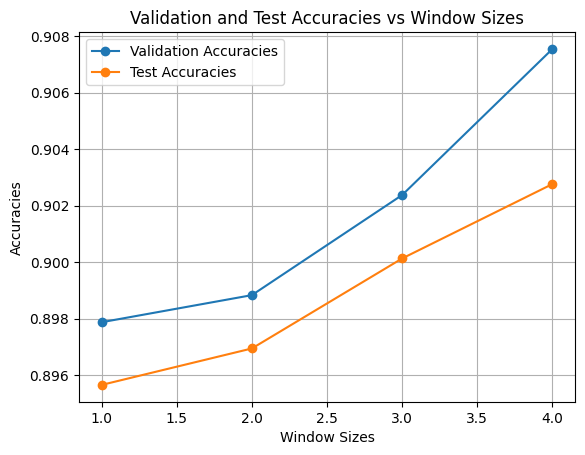

In [13]:
# Plot
plt.plot(window_sizes, val_accuracies, marker='o', label='Validation Accuracies')
plt.plot(window_sizes, test_accuracies, marker='o', label='Test Accuracies')
plt.xlabel('Window Sizes')
plt.ylabel('Accuracies')
plt.title('Validation and Test Accuracies vs Window Sizes')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
!ls -plia

total 667708
   524294 drwxr-xr-x 5 root root      4096 Mar 29 14:51  ./
271237109 drwxr-xr-x 5 root root      4096 Mar 29 14:34  ../
   655361 drwxr-xr-x 2 root root      4096 Mar 29 14:34  .virtual_documents/
   524295 drwxr-xr-x 3 root root      4096 Mar 29 14:34  corpora/
   524386 -rw-r--r-- 1 root root   6678865 Mar 29 14:38 'skip-gram-classification-model-w=1.pt'
   524384 -rw-r--r-- 1 root root   6678865 Mar 29 14:40 'skip-gram-classification-model-w=2.pt'
   524383 -rw-r--r-- 1 root root   6678865 Mar 29 14:44 'skip-gram-classification-model-w=3.pt'
   524381 -rw-r--r-- 1 root root   6678865 Mar 29 14:48 'skip-gram-classification-model-w=4.pt'
   524333 -rw-r--r-- 1 root root  70420170 Mar 29 14:34 'skip-gram-word-vectors-w=1.pt'
   524379 -rw-r--r-- 1 root root  70420170 Mar 29 14:34 'skip-gram-word-vectors-w=2.pt'
   524373 -rw-r--r-- 1 root root  70420170 Mar 29 14:34 'skip-gram-word-vectors-w=3.pt'
   524326 -rw-r--r-- 1 root root  70420170 Mar 29 14:34 'skip-gram-word-vec

In [14]:
!zip -r sgns.zip /kaggle/working/sk*
from IPython.display import FileLink
FileLink(r'sgns.zip')

  adding: kaggle/working/skip-gram-classification-model-w=1.pt (deflated 7%)
  adding: kaggle/working/skip-gram-classification-model-w=2.pt (deflated 7%)
  adding: kaggle/working/skip-gram-classification-model-w=3.pt (deflated 7%)
  adding: kaggle/working/skip-gram-classification-model-w=4.pt (deflated 7%)
  adding: kaggle/working/skip-gram-word-vectors-w=1.pt (deflated 23%)
  adding: kaggle/working/skip-gram-word-vectors-w=2.pt (deflated 23%)
  adding: kaggle/working/skip-gram-word-vectors-w=3.pt (deflated 23%)
  adding: kaggle/working/skip-gram-word-vectors-w=4.pt (deflated 23%)


/kaggle/working/sgns.zip

In [ ]:
# def word_similarity(target, vocab):
#     # if USE_CUDA:
#     #     target_V = model.prediction(prepare_word(target, word2index))
#     # else:
#     #     target_V = model.prediction(prepare_word(target, word2index))
#     target_V = model.prediction(prepare_word(target, word2index))
#     similarities = []
#     for i in range(len(vocab)):
#         if vocab[i] == target:
#             continue

#         # if USE_CUDA:
#         #     vector = model.prediction(prepare_word(list(vocab)[i], word2index))
#         # else:
#         #     vector = model.prediction(prepare_word(list(vocab)[i], word2index))
#         vector = model.prediction(prepare_word(list(vocab)[i], word2index))
#         cosine_sim = F.cosine_similarity(target_V, vector).data.tolist()[0]
#         similarities.append([vocab[i], cosine_sim])
#     return sorted(similarities, key=lambda x: x[1], reverse=True)[:10]

In [ ]:
# # test = random.choice(list(vocab))
# test = 'monday'
# word_similarity(test, vocab)


In [ ]:
# model.embedding_v.weight.data

In [ ]:
# print(len(vocab))
# print('<DUMMY>' in vocab)
# print('<UNK>' in vocab)

In [ ]:
# word2index